In [1]:
import torch
import kagglehub
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
# Download dataset
# data_dir = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

# print("Path to dataset files:", data_dir)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# # Hyperparameters
# batch_size = 256
# img_size = 128  # original image size is 128x128
# channels = 3  # rgb images
# latent_dim = 2
# num_epochs = 500  # training epochs 

# # transforms.ToTensor() scales pixels to [0,1]
# transform = transforms.Compose(
#     [
#         transforms.Lambda(lambda img: img.convert("RGB")),  # Convert to RGB
#         transforms.Resize((img_size, img_size)),
#         transforms.ToTensor(),
#     ]
# )

# # Load dataset using ImageFolder (expects subfolders per class)
# dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [5]:
# Hyperparameters
batch_size = 1024 * 2
img_size = 28  # original image size is 28x28
channels = 1  # grayscale image
latent_dim = 2
num_epochs = 300  # training epochs 

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
])

dataset = datasets.MNIST(
    root="./data",      # Data storage directory
    train=True,  
    transform=transform,  
    download=True, 
)

In [6]:
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 48000, Validation samples: 12000


In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        # Input: (1, 28, 28) - MNIST images are 28x28 grayscale
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)   # -> (16, 28, 28)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # -> (32, 14, 14)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # -> (64, 7, 7)
        
        # Compute flattened dimension (64 channels * 7 * 7)
        self.flatten_dim = 64 * 7 * 7
        
        # Fully connected layers for latent variables
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)      # -> (latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)  # -> (latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)  # -> (flatten_dim)
        # After fc_decode, we reshape to (64, 7, 7)
        # Then use ConvTranspose2d layers to upscale back to (1, 28, 28)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # (64,7,7) -> (32,14,14)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # (32,14,14) -> (16,28,28)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)  # (16,28,28) -> (1,28,28)
        
    def encode(self, x):
        # Input: (batch_size, 1, 28, 28)
        x = F.relu(self.conv1(x))       # (batch_size, 16, 28, 28)
        x = F.relu(self.conv2(x))       # (batch_size, 32, 14, 14)
        x = F.relu(self.conv3(x))       # (batch_size, 64, 7, 7)
        x = x.view(-1, self.flatten_dim) # (batch_size, 64*7*7)
        mu = self.fc_mu(x)              # (batch_size, latent_dim)
        logvar = self.fc_logvar(x)      # (batch_size, latent_dim)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Input: mu (batch_size, latent_dim), logvar (batch_size, latent_dim)
        std = torch.exp(0.5 * logvar)   # (batch_size, latent_dim)
        eps = torch.randn_like(std)     # (batch_size, latent_dim)
        return mu + eps * std           # (batch_size, latent_dim)
    
    def decode(self, z):
        # Input: z (batch_size, latent_dim)
        x = F.relu(self.fc_decode(z))   # (batch_size, flatten_dim)
        x = x.view(-1, 64, 7, 7)        # (batch_size, 64, 7, 7)
        x = F.relu(self.deconv1(x))     # (batch_size, 32, 14, 14)
        x = F.relu(self.deconv2(x))     # (batch_size, 16, 28, 28)
        x = torch.sigmoid(self.conv_final(x))  # (batch_size, 1, 28, 28)
        return x
    
    def forward(self, x):
        # Input: x (batch_size, 1, 28, 28)
        mu, logvar = self.encode(x)     # mu (batch_size, latent_dim), logvar (batch_size, latent_dim)
        z = self.reparameterize(mu, logvar)  # (batch_size, latent_dim)
        recon_x = self.decode(z)        # (batch_size, 1, 28, 28)
        return recon_x, mu, logvar

In [9]:
# def loss_function(recon_x, x, mu, log_var, B=1000):
#     # Flatten tensors for MSE calculation
#     recon_x_flat = recon_x.view(recon_x.size(0), -1)
#     x_flat = x.view(x.size(0), -1)
    
#     # Calculate MSE (per element average)
#     mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')
    
#     # Scale by input dimensions
#     reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]
    
#     # Calculate KL divergence
#     kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)
    
#     # Compute final loss (adding B*recon_loss + kl_loss)
#     total_loss = B * reconstruction_loss + torch.mean(kl_loss)
    
#     return total_loss, reconstruction_loss, torch.mean(kl_loss)

In [10]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for BCE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    
    # Calculate Binary Cross-Entropy loss
    bce_out = F.binary_cross_entropy(recon_x_flat, x_flat, reduction='mean')
    
    # Scale by input dimensions
    reconstruction_loss = bce_out * x.shape[1] * x.shape[2] * x.shape[3]
    
    # Calculate KL divergence (unchanged)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
    
    # Compute final loss
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)
    
    return total_loss, reconstruction_loss, torch.mean(kl_loss)

In [11]:
# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [12]:
# Print the summary of the model
summary(model, input_size=(channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 64, 7, 7]          18,496
            Linear-4                    [-1, 2]           6,274
            Linear-5                    [-1, 2]           6,274
            Linear-6                 [-1, 3136]           9,408
   ConvTranspose2d-7           [-1, 32, 14, 14]          18,464
   ConvTranspose2d-8           [-1, 16, 28, 28]           4,624
            Conv2d-9            [-1, 1, 28, 28]             145
Total params: 68,485
Trainable params: 68,485
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.26
Estimated Total Size (MB): 0.61
---------------------------------------------

In [13]:
# Disable UserWarning
import warnings
warnings.filterwarnings("ignore")

In [14]:
import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    # Create a progress bar for the batches of the current epoch
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # Update the inner progress bar with the current loss
        epoch_bar.set_postfix(loss=loss.item())
    
    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f}  "
          f"Recon Loss: {recon_loss.item():.4f}  KL Loss: {kl_loss.item():.4f}")
    
    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

# Log training completion
with open(log_file, "a") as f:
    f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Training log saved to {log_file}")

Epoch 1/300 Loss per sample: 222.0706  Recon Loss: 351.1010  KL Loss: 3.6278


Epoch 2/300 Loss per sample: 139.5409  Recon Loss: 222.8243  KL Loss: 23.3394


Epoch 3/300 Loss per sample: 105.6479  Recon Loss: 206.4019  KL Loss: 42.4177


Epoch 4/300 Loss per sample: 102.6354  Recon Loss: 201.6789  KL Loss: 42.2311


Epoch 5/300 Loss per sample: 100.9112  Recon Loss: 198.3688  KL Loss: 37.0179


Epoch 6/300 Loss per sample: 98.3291  Recon Loss: 191.7333  KL Loss: 48.3202


Epoch 7/300 Loss per sample: 94.5424  Recon Loss: 186.1925  KL Loss: 53.2855


Epoch 8/300 Loss per sample: 92.3599  Recon Loss: 180.9593  KL Loss: 49.1511


Epoch 9/300 Loss per sample: 90.9994  Recon Loss: 178.9750  KL Loss: 44.1150


Epoch 10/300 Loss per sample: 89.8958  Recon Loss: 177.7534  KL Loss: 39.5187


Epoch 11/300 Loss per sample: 89.0413  Recon Loss: 178.0551  KL Loss: 35.4165


Epoch 12/300 Loss per sample: 88.3009  Recon Loss: 177.7980  KL Loss: 32.9161


Epoch 13/300 Loss per sample: 87.7068  Recon Loss: 178.9554  KL Loss: 30.4423


Epoch 14/300 Loss per sample: 87.1657  Recon Loss: 175.4512  KL Loss: 27.6089


Epoch 15/300 Loss per sample: 86.7007  Recon Loss: 174.6055  KL Loss: 28.2442


Epoch 16/300 Loss per sample: 86.2982  Recon Loss: 173.1524  KL Loss: 27.4629


Epoch 17/300 Loss per sample: 85.8630  Recon Loss: 170.0594  KL Loss: 27.2711


Epoch 18/300 Loss per sample: 85.4867  Recon Loss: 172.5328  KL Loss: 24.6760


Epoch 19/300 Loss per sample: 84.9449  Recon Loss: 171.7550  KL Loss: 24.9812


Epoch 20/300 Loss per sample: 84.2709  Recon Loss: 165.9751  KL Loss: 25.4575


Epoch 21/300 Loss per sample: 83.7390  Recon Loss: 169.0370  KL Loss: 25.0386


Epoch 22/300 Loss per sample: 83.2387  Recon Loss: 166.6239  KL Loss: 26.1887


Epoch 23/300 Loss per sample: 82.8169  Recon Loss: 162.6529  KL Loss: 26.9765


Epoch 24/300 Loss per sample: 82.5342  Recon Loss: 166.7805  KL Loss: 26.2531


Epoch 25/300 Loss per sample: 82.1004  Recon Loss: 161.5748  KL Loss: 27.2978


Epoch 26/300 Loss per sample: 81.8298  Recon Loss: 163.9316  KL Loss: 26.5700


Epoch 27/300 Loss per sample: 81.5048  Recon Loss: 164.9160  KL Loss: 25.8190


Epoch 28/300 Loss per sample: 81.2805  Recon Loss: 161.5279  KL Loss: 26.9598


Epoch 29/300 Loss per sample: 81.1135  Recon Loss: 161.9894  KL Loss: 25.9530


Epoch 30/300 Loss per sample: 80.7297  Recon Loss: 159.2385  KL Loss: 27.2562


Epoch 31/300 Loss per sample: 80.5217  Recon Loss: 159.5930  KL Loss: 27.1749


Epoch 32/300 Loss per sample: 80.3172  Recon Loss: 157.2620  KL Loss: 28.1791


Epoch 33/300 Loss per sample: 80.2408  Recon Loss: 160.8119  KL Loss: 26.8537


Epoch 34/300 Loss per sample: 79.9984  Recon Loss: 160.1221  KL Loss: 27.1742


Epoch 35/300 Loss per sample: 79.8260  Recon Loss: 159.2716  KL Loss: 27.6225


Epoch 36/300 Loss per sample: 79.7461  Recon Loss: 159.7696  KL Loss: 25.9929


Epoch 37/300 Loss per sample: 79.4929  Recon Loss: 156.9063  KL Loss: 28.0961


Epoch 38/300 Loss per sample: 79.3663  Recon Loss: 159.6681  KL Loss: 24.8210


Epoch 39/300 Loss per sample: 79.2012  Recon Loss: 158.6515  KL Loss: 27.1250


Epoch 40/300 Loss per sample: 79.0443  Recon Loss: 155.3639  KL Loss: 28.0527


Epoch 41/300 Loss per sample: 78.9138  Recon Loss: 159.1220  KL Loss: 26.8369


Epoch 42/300 Loss per sample: 78.7569  Recon Loss: 155.8165  KL Loss: 26.8290


Epoch 43/300 Loss per sample: 78.6190  Recon Loss: 156.2966  KL Loss: 27.5989


Epoch 44/300 Loss per sample: 78.5752  Recon Loss: 155.6709  KL Loss: 27.7305


Epoch 45/300 Loss per sample: 78.4756  Recon Loss: 156.0513  KL Loss: 26.1496


Epoch 46/300 Loss per sample: 78.1926  Recon Loss: 156.8216  KL Loss: 26.8563


Epoch 47/300 Loss per sample: 77.9607  Recon Loss: 153.2357  KL Loss: 28.2875


Epoch 48/300 Loss per sample: 77.8032  Recon Loss: 153.2578  KL Loss: 27.3827


Epoch 49/300 Loss per sample: 77.7835  Recon Loss: 156.0789  KL Loss: 27.5783


Epoch 50/300 Loss per sample: 77.6446  Recon Loss: 153.6848  KL Loss: 27.8920


Epoch 51/300 Loss per sample: 77.6763  Recon Loss: 154.6521  KL Loss: 26.7606


Epoch 52/300 Loss per sample: 77.3676  Recon Loss: 152.4078  KL Loss: 28.0509


Epoch 53/300 Loss per sample: 77.3804  Recon Loss: 154.2751  KL Loss: 27.0607


Epoch 54/300 Loss per sample: 77.2809  Recon Loss: 155.7456  KL Loss: 26.0292


Epoch 55/300 Loss per sample: 77.0543  Recon Loss: 155.9498  KL Loss: 26.2960


Epoch 56/300 Loss per sample: 77.0286  Recon Loss: 158.0551  KL Loss: 25.5669


Epoch 57/300 Loss per sample: 76.8273  Recon Loss: 152.7639  KL Loss: 27.6649


Epoch 58/300 Loss per sample: 76.6861  Recon Loss: 152.3475  KL Loss: 26.7304


Epoch 59/300 Loss per sample: 76.5789  Recon Loss: 154.0124  KL Loss: 26.8783


Epoch 60/300 Loss per sample: 76.5486  Recon Loss: 152.1190  KL Loss: 28.1741


Epoch 61/300 Loss per sample: 76.6069  Recon Loss: 153.4522  KL Loss: 26.9127


Epoch 62/300 Loss per sample: 76.2906  Recon Loss: 153.0111  KL Loss: 26.7092


Epoch 63/300 Loss per sample: 76.4972  Recon Loss: 153.0362  KL Loss: 25.3718


Epoch 64/300 Loss per sample: 76.1267  Recon Loss: 152.1146  KL Loss: 27.3765


Epoch 65/300 Loss per sample: 76.0168  Recon Loss: 150.1467  KL Loss: 27.0399


Epoch 66/300 Loss per sample: 75.9521  Recon Loss: 150.3874  KL Loss: 27.4283


Epoch 67/300 Loss per sample: 75.9416  Recon Loss: 151.4135  KL Loss: 26.0374


Epoch 68/300 Loss per sample: 76.0603  Recon Loss: 151.2247  KL Loss: 26.8961


Epoch 69/300 Loss per sample: 76.3236  Recon Loss: 150.7914  KL Loss: 26.8697


Epoch 70/300 Loss per sample: 75.7471  Recon Loss: 150.0390  KL Loss: 26.1784


Epoch 71/300 Loss per sample: 75.6061  Recon Loss: 150.0931  KL Loss: 26.9852


Epoch 72/300 Loss per sample: 75.5169  Recon Loss: 151.1689  KL Loss: 26.2004


Epoch 73/300 Loss per sample: 75.5194  Recon Loss: 149.3470  KL Loss: 26.5400


Epoch 74/300 Loss per sample: 75.4179  Recon Loss: 149.2973  KL Loss: 26.4575


Epoch 75/300 Loss per sample: 75.3760  Recon Loss: 148.8167  KL Loss: 26.1945


Epoch 76/300 Loss per sample: 75.3569  Recon Loss: 151.1768  KL Loss: 25.7243


Epoch 77/300 Loss per sample: 75.2787  Recon Loss: 149.0409  KL Loss: 27.7526


Epoch 78/300 Loss per sample: 75.1956  Recon Loss: 151.0615  KL Loss: 27.2077


Epoch 79/300 Loss per sample: 75.0962  Recon Loss: 149.3645  KL Loss: 27.1158


Epoch 80/300 Loss per sample: 75.1648  Recon Loss: 150.7508  KL Loss: 25.5993


Epoch 81/300 Loss per sample: 75.2582  Recon Loss: 151.6118  KL Loss: 25.0768


Epoch 82/300 Loss per sample: 75.0701  Recon Loss: 147.9330  KL Loss: 26.5433


Epoch 83/300 Loss per sample: 74.9714  Recon Loss: 152.3482  KL Loss: 25.7233


Epoch 84/300 Loss per sample: 74.8800  Recon Loss: 148.6536  KL Loss: 25.7915


Epoch 85/300 Loss per sample: 74.8743  Recon Loss: 150.4730  KL Loss: 26.6148


Epoch 86/300 Loss per sample: 74.9714  Recon Loss: 153.5213  KL Loss: 25.7952


Epoch 87/300 Loss per sample: 74.7949  Recon Loss: 150.1501  KL Loss: 25.9511


Epoch 88/300 Loss per sample: 74.9496  Recon Loss: 148.6950  KL Loss: 25.4744


Epoch 89/300 Loss per sample: 74.6783  Recon Loss: 147.3011  KL Loss: 25.5026


Epoch 90/300 Loss per sample: 74.6878  Recon Loss: 151.1188  KL Loss: 24.8394


Epoch 91/300 Loss per sample: 74.5469  Recon Loss: 148.6042  KL Loss: 26.0671


Epoch 92/300 Loss per sample: 74.7402  Recon Loss: 152.5256  KL Loss: 24.9937


Epoch 93/300 Loss per sample: 74.5221  Recon Loss: 149.2880  KL Loss: 26.1672


Epoch 94/300 Loss per sample: 74.6223  Recon Loss: 153.3309  KL Loss: 26.5824


Epoch 95/300 Loss per sample: 74.6023  Recon Loss: 149.0141  KL Loss: 25.7233


Epoch 96/300 Loss per sample: 74.3382  Recon Loss: 149.2125  KL Loss: 24.8095


Epoch 97/300 Loss per sample: 74.3114  Recon Loss: 150.3131  KL Loss: 24.9593


Epoch 98/300 Loss per sample: 74.3154  Recon Loss: 149.4773  KL Loss: 26.1526


Epoch 99/300 Loss per sample: 74.2027  Recon Loss: 148.7195  KL Loss: 26.0216


Epoch 100/300 Loss per sample: 74.2917  Recon Loss: 147.3978  KL Loss: 25.8445


Epoch 101/300 Loss per sample: 74.3915  Recon Loss: 150.4276  KL Loss: 24.5609


Epoch 102/300 Loss per sample: 74.1808  Recon Loss: 148.5745  KL Loss: 25.7244


Epoch 103/300 Loss per sample: 74.1026  Recon Loss: 150.0536  KL Loss: 25.2653


Epoch 104/300 Loss per sample: 74.1471  Recon Loss: 149.6758  KL Loss: 26.2995


Epoch 105/300 Loss per sample: 74.1144  Recon Loss: 149.1415  KL Loss: 24.6728


Epoch 106/300 Loss per sample: 73.9710  Recon Loss: 146.8630  KL Loss: 25.8223


Epoch 107/300 Loss per sample: 74.0868  Recon Loss: 150.9360  KL Loss: 23.7733


Epoch 108/300 Loss per sample: 73.9940  Recon Loss: 144.3125  KL Loss: 26.4818


Epoch 109/300 Loss per sample: 74.2156  Recon Loss: 147.7522  KL Loss: 24.5538


Epoch 110/300 Loss per sample: 73.9882  Recon Loss: 147.0643  KL Loss: 24.5718


Epoch 111/300 Loss per sample: 73.8989  Recon Loss: 145.5615  KL Loss: 25.5241


Epoch 112/300 Loss per sample: 73.8635  Recon Loss: 144.4670  KL Loss: 25.6511


Epoch 113/300 Loss per sample: 73.8174  Recon Loss: 145.4041  KL Loss: 25.4906


Epoch 114/300 Loss per sample: 73.8176  Recon Loss: 149.4847  KL Loss: 24.4983


Epoch 115/300 Loss per sample: 73.7008  Recon Loss: 146.7690  KL Loss: 25.7846


Epoch 116/300 Loss per sample: 73.8529  Recon Loss: 151.1101  KL Loss: 24.8263


Epoch 117/300 Loss per sample: 73.7089  Recon Loss: 147.5920  KL Loss: 24.5342


Epoch 118/300 Loss per sample: 73.8211  Recon Loss: 148.4631  KL Loss: 24.7420


Epoch 119/300 Loss per sample: 73.6706  Recon Loss: 144.2983  KL Loss: 25.4230


Epoch 120/300 Loss per sample: 73.6519  Recon Loss: 148.9209  KL Loss: 24.6067


Epoch 121/300 Loss per sample: 73.5259  Recon Loss: 146.4141  KL Loss: 25.9503


Epoch 122/300 Loss per sample: 73.4961  Recon Loss: 146.0533  KL Loss: 25.6816


Epoch 123/300 Loss per sample: 73.5958  Recon Loss: 146.6220  KL Loss: 25.2261


Epoch 124/300 Loss per sample: 73.4622  Recon Loss: 146.7053  KL Loss: 25.6318


Epoch 125/300 Loss per sample: 73.5396  Recon Loss: 147.4956  KL Loss: 24.7168


Epoch 126/300 Loss per sample: 73.4166  Recon Loss: 147.5959  KL Loss: 24.9133


Epoch 127/300 Loss per sample: 73.4577  Recon Loss: 147.8158  KL Loss: 25.4185


Epoch 128/300 Loss per sample: 73.6391  Recon Loss: 148.0737  KL Loss: 24.1930


Epoch 129/300 Loss per sample: 73.5006  Recon Loss: 147.2952  KL Loss: 25.2802


Epoch 130/300 Loss per sample: 73.3183  Recon Loss: 147.9685  KL Loss: 25.3745


Epoch 131/300 Loss per sample: 73.3113  Recon Loss: 150.1666  KL Loss: 23.9960


Epoch 132/300 Loss per sample: 73.4327  Recon Loss: 145.1423  KL Loss: 25.5334


Epoch 133/300 Loss per sample: 73.3602  Recon Loss: 148.4793  KL Loss: 24.6764


Epoch 134/300 Loss per sample: 73.3779  Recon Loss: 147.6220  KL Loss: 24.8268


Epoch 135/300 Loss per sample: 73.2598  Recon Loss: 145.8404  KL Loss: 25.3881


Epoch 136/300 Loss per sample: 73.1929  Recon Loss: 146.5817  KL Loss: 24.1598


Epoch 137/300 Loss per sample: 73.1337  Recon Loss: 144.6245  KL Loss: 24.3264


Epoch 138/300 Loss per sample: 73.1244  Recon Loss: 146.6953  KL Loss: 24.9019


Epoch 139/300 Loss per sample: 73.1327  Recon Loss: 146.7033  KL Loss: 25.0237


Epoch 140/300 Loss per sample: 73.4832  Recon Loss: 145.4238  KL Loss: 24.6692


Epoch 141/300 Loss per sample: 73.3328  Recon Loss: 147.4470  KL Loss: 24.5246


Epoch 142/300 Loss per sample: 73.2825  Recon Loss: 144.3568  KL Loss: 24.5267


Epoch 143/300 Loss per sample: 73.0803  Recon Loss: 144.6251  KL Loss: 25.4132


Epoch 144/300 Loss per sample: 73.1468  Recon Loss: 146.0578  KL Loss: 24.6582


Epoch 145/300 Loss per sample: 73.0148  Recon Loss: 146.6470  KL Loss: 24.6638


Epoch 146/300 Loss per sample: 72.9606  Recon Loss: 146.3296  KL Loss: 25.0287


Epoch 147/300 Loss per sample: 72.9645  Recon Loss: 146.8263  KL Loss: 24.8435


Epoch 148/300 Loss per sample: 72.9479  Recon Loss: 146.9892  KL Loss: 23.6863


Epoch 149/300 Loss per sample: 72.9350  Recon Loss: 146.8393  KL Loss: 24.6713


Epoch 150/300 Loss per sample: 72.9036  Recon Loss: 146.8493  KL Loss: 25.1728


Epoch 151/300 Loss per sample: 73.0254  Recon Loss: 149.2366  KL Loss: 24.0818


Epoch 152/300 Loss per sample: 72.8098  Recon Loss: 146.3855  KL Loss: 25.1582


Epoch 153/300 Loss per sample: 73.0876  Recon Loss: 145.0196  KL Loss: 24.7018


Epoch 154/300 Loss per sample: 72.9812  Recon Loss: 146.8306  KL Loss: 24.5152


Epoch 155/300 Loss per sample: 72.9385  Recon Loss: 145.9507  KL Loss: 23.9014


Epoch 156/300 Loss per sample: 72.9036  Recon Loss: 146.2218  KL Loss: 24.8269


Epoch 157/300 Loss per sample: 72.7876  Recon Loss: 141.9383  KL Loss: 25.1895


Epoch 158/300 Loss per sample: 72.8517  Recon Loss: 144.3190  KL Loss: 24.6773


Epoch 159/300 Loss per sample: 72.6802  Recon Loss: 144.1611  KL Loss: 24.8998


Epoch 160/300 Loss per sample: 72.7321  Recon Loss: 144.9480  KL Loss: 25.4736


Epoch 161/300 Loss per sample: 72.6460  Recon Loss: 142.9626  KL Loss: 25.0986


Epoch 162/300 Loss per sample: 72.7540  Recon Loss: 147.3035  KL Loss: 24.3477


Epoch 163/300 Loss per sample: 72.9515  Recon Loss: 146.0690  KL Loss: 24.9559


Epoch 164/300 Loss per sample: 72.6149  Recon Loss: 143.6420  KL Loss: 25.1764


Epoch 165/300 Loss per sample: 72.6764  Recon Loss: 147.0882  KL Loss: 24.4764


Epoch 166/300 Loss per sample: 72.6035  Recon Loss: 145.3882  KL Loss: 24.5569


Epoch 167/300 Loss per sample: 72.7663  Recon Loss: 143.9661  KL Loss: 25.0046


Epoch 168/300 Loss per sample: 73.0550  Recon Loss: 147.8309  KL Loss: 23.9317


Epoch 169/300 Loss per sample: 72.5878  Recon Loss: 143.8209  KL Loss: 24.3623


Epoch 170/300 Loss per sample: 72.7731  Recon Loss: 148.8223  KL Loss: 23.2001


Epoch 171/300 Loss per sample: 72.5949  Recon Loss: 148.7876  KL Loss: 23.2882


Epoch 172/300 Loss per sample: 72.5873  Recon Loss: 144.7493  KL Loss: 23.9224


Epoch 173/300 Loss per sample: 72.5182  Recon Loss: 143.5976  KL Loss: 24.3950


Epoch 174/300 Loss per sample: 72.4502  Recon Loss: 142.2499  KL Loss: 24.9941


Epoch 175/300 Loss per sample: 72.5119  Recon Loss: 144.7747  KL Loss: 24.3562


Epoch 176/300 Loss per sample: 72.5448  Recon Loss: 144.4596  KL Loss: 23.9631


Epoch 177/300 Loss per sample: 72.5185  Recon Loss: 145.8196  KL Loss: 24.1580


Epoch 178/300 Loss per sample: 72.6588  Recon Loss: 146.4057  KL Loss: 24.1687


Epoch 179/300 Loss per sample: 72.4270  Recon Loss: 145.5839  KL Loss: 24.0037


Epoch 180/300 Loss per sample: 72.3951  Recon Loss: 144.5932  KL Loss: 24.7384


Epoch 181/300 Loss per sample: 72.5736  Recon Loss: 148.8268  KL Loss: 24.1077


Epoch 182/300 Loss per sample: 72.5245  Recon Loss: 141.9286  KL Loss: 24.1094


Epoch 183/300 Loss per sample: 72.3236  Recon Loss: 145.7953  KL Loss: 23.7744


Epoch 184/300 Loss per sample: 72.4159  Recon Loss: 143.4929  KL Loss: 25.0387


Epoch 185/300 Loss per sample: 72.3681  Recon Loss: 143.1677  KL Loss: 23.8541


Epoch 186/300 Loss per sample: 72.3543  Recon Loss: 143.6290  KL Loss: 24.9263


Epoch 187/300 Loss per sample: 72.4328  Recon Loss: 144.6450  KL Loss: 23.8687


Epoch 188/300 Loss per sample: 72.3248  Recon Loss: 142.3140  KL Loss: 24.0761


Epoch 189/300 Loss per sample: 72.3320  Recon Loss: 141.5265  KL Loss: 25.3860


Epoch 190/300 Loss per sample: 72.4211  Recon Loss: 143.9634  KL Loss: 25.1490


Epoch 191/300 Loss per sample: 72.2164  Recon Loss: 141.1883  KL Loss: 24.9059


Epoch 192/300 Loss per sample: 72.2110  Recon Loss: 141.6330  KL Loss: 24.7329


Epoch 193/300 Loss per sample: 72.4764  Recon Loss: 142.1508  KL Loss: 24.1085


Epoch 194/300 Loss per sample: 72.4528  Recon Loss: 148.5508  KL Loss: 23.1252


Epoch 195/300 Loss per sample: 72.0941  Recon Loss: 140.3128  KL Loss: 25.3577


Epoch 196/300 Loss per sample: 72.1567  Recon Loss: 143.9527  KL Loss: 24.3329


Epoch 197/300 Loss per sample: 72.1947  Recon Loss: 145.1753  KL Loss: 24.4087


Epoch 198/300 Loss per sample: 72.2913  Recon Loss: 140.6797  KL Loss: 24.9838


Epoch 199/300 Loss per sample: 72.2124  Recon Loss: 144.8813  KL Loss: 25.3888


Epoch 200/300 Loss per sample: 72.1878  Recon Loss: 143.8540  KL Loss: 23.6645


Epoch 201/300 Loss per sample: 72.1772  Recon Loss: 144.4672  KL Loss: 24.1307


Epoch 202/300 Loss per sample: 72.3079  Recon Loss: 147.1049  KL Loss: 23.9768


Epoch 203/300 Loss per sample: 72.1212  Recon Loss: 144.4386  KL Loss: 24.5193


Epoch 204/300 Loss per sample: 72.1482  Recon Loss: 144.3310  KL Loss: 23.7498


Epoch 205/300 Loss per sample: 71.9618  Recon Loss: 142.7911  KL Loss: 23.7191


Epoch 206/300 Loss per sample: 72.0515  Recon Loss: 143.5956  KL Loss: 24.2169


Epoch 207/300 Loss per sample: 72.3664  Recon Loss: 145.2372  KL Loss: 24.5008


Epoch 208/300 Loss per sample: 72.4308  Recon Loss: 142.8398  KL Loss: 24.0315


Epoch 209/300 Loss per sample: 72.0021  Recon Loss: 144.7962  KL Loss: 24.1449


Epoch 210/300 Loss per sample: 71.9802  Recon Loss: 144.5822  KL Loss: 24.2233


Epoch 211/300 Loss per sample: 72.1521  Recon Loss: 145.5714  KL Loss: 25.0486


Epoch 212/300 Loss per sample: 72.0132  Recon Loss: 144.9160  KL Loss: 24.2986


Epoch 213/300 Loss per sample: 71.9543  Recon Loss: 143.7796  KL Loss: 24.9652


Epoch 214/300 Loss per sample: 72.0801  Recon Loss: 143.7277  KL Loss: 24.0669


Epoch 215/300 Loss per sample: 72.0376  Recon Loss: 144.4123  KL Loss: 23.9978


Epoch 216/300 Loss per sample: 71.9458  Recon Loss: 147.6108  KL Loss: 24.3260


Epoch 217/300 Loss per sample: 71.9508  Recon Loss: 144.3243  KL Loss: 23.6648


Epoch 218/300 Loss per sample: 72.0464  Recon Loss: 144.6357  KL Loss: 22.8897


Epoch 219/300 Loss per sample: 72.2485  Recon Loss: 146.7642  KL Loss: 23.7589


Epoch 220/300 Loss per sample: 71.9239  Recon Loss: 142.8189  KL Loss: 24.4969


Epoch 221/300 Loss per sample: 71.8960  Recon Loss: 145.5660  KL Loss: 23.6324


Epoch 222/300 Loss per sample: 71.8560  Recon Loss: 142.6640  KL Loss: 24.9596


Epoch 223/300 Loss per sample: 71.8861  Recon Loss: 146.3529  KL Loss: 23.1376


Epoch 224/300 Loss per sample: 71.8752  Recon Loss: 144.3208  KL Loss: 23.6454


Epoch 225/300 Loss per sample: 72.1613  Recon Loss: 146.2706  KL Loss: 22.6254


Epoch 226/300 Loss per sample: 71.9561  Recon Loss: 144.2479  KL Loss: 23.7490


Epoch 227/300 Loss per sample: 72.1980  Recon Loss: 143.8653  KL Loss: 24.1281


Epoch 228/300 Loss per sample: 71.9537  Recon Loss: 144.1351  KL Loss: 23.6389


Epoch 229/300 Loss per sample: 71.9031  Recon Loss: 146.6742  KL Loss: 23.2174


Epoch 230/300 Loss per sample: 71.8461  Recon Loss: 145.0279  KL Loss: 24.2324


Epoch 231/300 Loss per sample: 72.0041  Recon Loss: 145.0890  KL Loss: 23.4409


Epoch 232/300 Loss per sample: 72.1923  Recon Loss: 145.8791  KL Loss: 23.4232


Epoch 233/300 Loss per sample: 72.0922  Recon Loss: 141.1990  KL Loss: 24.0642


Epoch 234/300 Loss per sample: 71.6952  Recon Loss: 143.8635  KL Loss: 23.4715


Epoch 235/300 Loss per sample: 71.6687  Recon Loss: 143.2258  KL Loss: 24.4350


Epoch 236/300 Loss per sample: 71.6598  Recon Loss: 143.3156  KL Loss: 23.2689


Epoch 237/300 Loss per sample: 71.7058  Recon Loss: 146.7875  KL Loss: 23.3891


Epoch 238/300 Loss per sample: 71.8596  Recon Loss: 144.6447  KL Loss: 24.5510


Epoch 239/300 Loss per sample: 71.7191  Recon Loss: 142.8124  KL Loss: 22.7710


Epoch 240/300 Loss per sample: 71.8574  Recon Loss: 144.8393  KL Loss: 23.2768


Epoch 241/300 Loss per sample: 71.7142  Recon Loss: 144.6006  KL Loss: 22.9477


Epoch 242/300 Loss per sample: 71.6610  Recon Loss: 143.8717  KL Loss: 23.1844


Epoch 243/300 Loss per sample: 71.6842  Recon Loss: 141.9297  KL Loss: 23.5611


Epoch 244/300 Loss per sample: 71.6970  Recon Loss: 147.8584  KL Loss: 22.8611


Epoch 245/300 Loss per sample: 71.7548  Recon Loss: 142.4561  KL Loss: 23.8187


Epoch 246/300 Loss per sample: 71.5888  Recon Loss: 144.8823  KL Loss: 23.5970


Epoch 247/300 Loss per sample: 71.7159  Recon Loss: 141.7143  KL Loss: 23.0179


Epoch 248/300 Loss per sample: 72.0321  Recon Loss: 143.8722  KL Loss: 23.3735


Epoch 249/300 Loss per sample: 71.6359  Recon Loss: 143.5272  KL Loss: 23.0462


Epoch 250/300 Loss per sample: 71.7365  Recon Loss: 146.4579  KL Loss: 23.1463


Epoch 251/300 Loss per sample: 71.6306  Recon Loss: 143.6585  KL Loss: 23.7118


Epoch 252/300 Loss per sample: 71.5104  Recon Loss: 142.5914  KL Loss: 23.7954


Epoch 253/300 Loss per sample: 71.6303  Recon Loss: 144.7522  KL Loss: 23.8609


Epoch 254/300 Loss per sample: 71.7228  Recon Loss: 143.1378  KL Loss: 24.2480


Epoch 255/300 Loss per sample: 71.5934  Recon Loss: 143.2802  KL Loss: 23.4809


Epoch 256/300 Loss per sample: 71.5174  Recon Loss: 144.5138  KL Loss: 24.3152


Epoch 257/300 Loss per sample: 71.4988  Recon Loss: 146.0725  KL Loss: 22.9768


Epoch 258/300 Loss per sample: 71.5806  Recon Loss: 144.5942  KL Loss: 22.7592


Epoch 259/300 Loss per sample: 71.5513  Recon Loss: 143.5543  KL Loss: 23.4206


Epoch 260/300 Loss per sample: 71.4978  Recon Loss: 140.3850  KL Loss: 24.2475


Epoch 261/300 Loss per sample: 71.7948  Recon Loss: 142.8666  KL Loss: 23.2214


Epoch 262/300 Loss per sample: 71.8011  Recon Loss: 141.1322  KL Loss: 23.0369


Epoch 263/300 Loss per sample: 71.5174  Recon Loss: 144.8275  KL Loss: 23.4554


Epoch 264/300 Loss per sample: 71.4162  Recon Loss: 143.4910  KL Loss: 23.5434


Epoch 265/300 Loss per sample: 71.4535  Recon Loss: 143.8363  KL Loss: 22.8616


Epoch 266/300 Loss per sample: 71.4701  Recon Loss: 142.1022  KL Loss: 23.4719


Epoch 267/300 Loss per sample: 71.4387  Recon Loss: 145.5874  KL Loss: 23.1500


Epoch 268/300 Loss per sample: 71.5719  Recon Loss: 146.6171  KL Loss: 23.2746


Epoch 269/300 Loss per sample: 71.6286  Recon Loss: 144.3035  KL Loss: 22.5216


Epoch 270/300 Loss per sample: 71.5557  Recon Loss: 143.3874  KL Loss: 23.4822


Epoch 271/300 Loss per sample: 71.4331  Recon Loss: 144.0475  KL Loss: 23.5888


Epoch 272/300 Loss per sample: 71.4332  Recon Loss: 142.3044  KL Loss: 24.7312


Epoch 273/300 Loss per sample: 71.3762  Recon Loss: 142.5306  KL Loss: 23.2661


Epoch 274/300 Loss per sample: 71.3898  Recon Loss: 142.1137  KL Loss: 23.9518


Epoch 275/300 Loss per sample: 71.3776  Recon Loss: 138.3132  KL Loss: 24.7828


Epoch 276/300 Loss per sample: 71.6162  Recon Loss: 141.4737  KL Loss: 23.2103


Epoch 277/300 Loss per sample: 71.3490  Recon Loss: 142.6902  KL Loss: 23.1716


Epoch 278/300 Loss per sample: 71.4116  Recon Loss: 146.7731  KL Loss: 22.7403


Epoch 279/300 Loss per sample: 71.3532  Recon Loss: 144.0104  KL Loss: 23.1066


Epoch 280/300 Loss per sample: 71.4235  Recon Loss: 141.6711  KL Loss: 22.6698


Epoch 281/300 Loss per sample: 71.5644  Recon Loss: 139.8304  KL Loss: 23.3311


Epoch 282/300 Loss per sample: 71.4004  Recon Loss: 144.6299  KL Loss: 22.8002


Epoch 283/300 Loss per sample: 71.2904  Recon Loss: 140.5527  KL Loss: 23.7368


Epoch 284/300 Loss per sample: 71.4069  Recon Loss: 143.7112  KL Loss: 23.0723


Epoch 285/300 Loss per sample: 71.7022  Recon Loss: 139.8176  KL Loss: 24.0076


Epoch 286/300 Loss per sample: 71.2719  Recon Loss: 141.0423  KL Loss: 23.8944


Epoch 287/300 Loss per sample: 71.2782  Recon Loss: 141.2218  KL Loss: 23.8038


Epoch 288/300 Loss per sample: 71.1631  Recon Loss: 140.1804  KL Loss: 22.9358


Epoch 289/300 Loss per sample: 71.2905  Recon Loss: 141.2741  KL Loss: 23.0569


Epoch 290/300 Loss per sample: 71.4002  Recon Loss: 142.0921  KL Loss: 23.0143


Epoch 291/300 Loss per sample: 71.6265  Recon Loss: 143.4454  KL Loss: 22.5310


Epoch 292/300 Loss per sample: 71.2437  Recon Loss: 142.9528  KL Loss: 23.8421


Epoch 293/300 Loss per sample: 71.1318  Recon Loss: 141.0978  KL Loss: 23.3416


Epoch 294/300 Loss per sample: 71.2279  Recon Loss: 141.6727  KL Loss: 23.5357


Epoch 295/300 Loss per sample: 71.1413  Recon Loss: 140.0907  KL Loss: 24.0266


Epoch 296/300 Loss per sample: 71.2831  Recon Loss: 143.0885  KL Loss: 23.4243


Epoch 297/300 Loss per sample: 71.5380  Recon Loss: 139.3739  KL Loss: 22.8282


Epoch 298/300 Loss per sample: 71.2424  Recon Loss: 143.8908  KL Loss: 23.1221


Epoch 299/300 Loss per sample: 71.3532  Recon Loss: 143.3160  KL Loss: 22.7222


Epoch 300/300 Loss per sample: 71.1734  Recon Loss: 141.2090  KL Loss: 23.1497
Training log saved to logs/training_log_20250319_085930.txt


In [15]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

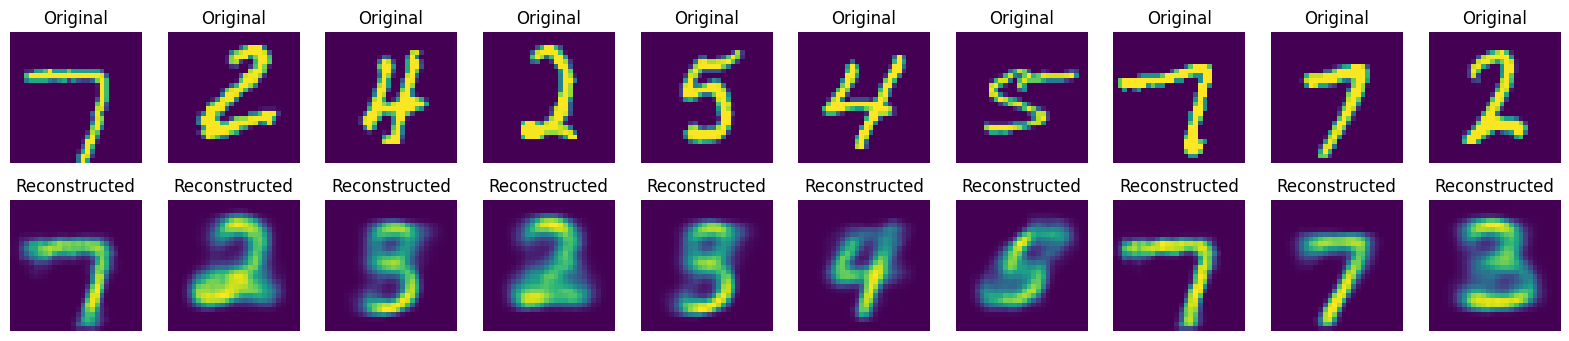

In [16]:
# Plot original and reconstructed images side by side
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [17]:
# Generate new images from random latent vectors
num_samples = 10
with torch.no_grad():
    z_random = torch.randn(num_samples, latent_dim).to(device)
    generated = model.decode(z_random)

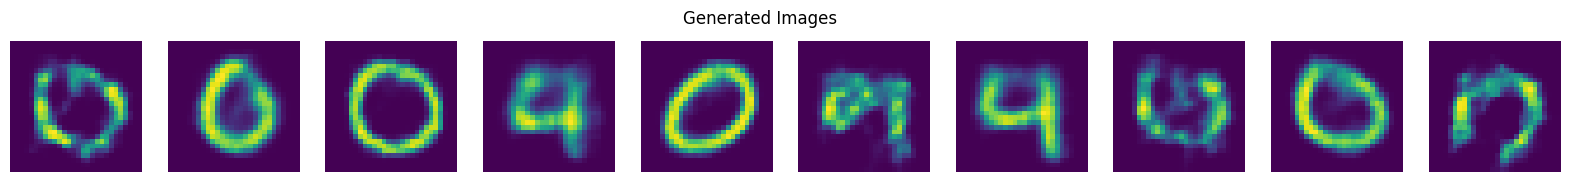

In [18]:
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    gen = generated[i].cpu().permute(1, 2, 0).numpy()
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(gen)
    plt.axis('off')
plt.suptitle("Generated Images")
plt.show()